# 1. Imports

In [1]:
import requests
import pandas as pd
import numpy as np
from tqdm import tqdm
import time
from datetime import datetime as dt
import ast
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import random as random

import warnings
warnings.filterwarnings("ignore")

# 2. Read in dataset

In [2]:
df = pd.read_csv('checkpoint_4.csv')
df.rename(columns = {'Area (km²)': 'area_km_sq', 'Density (/km²)': 'density_km_sq'}, inplace=True)
df['resell_date'] = df['resell_date'].apply(lambda x: dt.strptime(x, "%Y-%m-%d"))
df.head()

,town,flat_type,flat_model,floor_area_sqm,street_name,resale_price,lease_commence_date,storey_range,block,remaining_lease_mth,...,closest_park_dist,closest_park,num_park_1km_radius,price_per_sqm,num_of_dwellings_in_town,Region,area_km_sq,Population,density_km_sq,resell_date
0,ANG MO KIO,2 ROOM,Improved,44.0,ANG MO KIO AVE 10,232000.0,1979.0,10 TO 12,406,736,...,1032.586022,Ang Mo Kio Town Garden East,0,5272.727273,61730.0,North-East,13.94,161000.0,13400.0,2017-01-01
1,ANG MO KIO,3 ROOM,New Generation,67.0,ANG MO KIO AVE 4,250000.0,1978.0,01 TO 03,108,727,...,658.451197,Ang Mo Kio Town Garden West,2,3731.343284,61730.0,North-East,13.94,161000.0,13400.0,2017-01-01
2,ANG MO KIO,3 ROOM,New Generation,67.0,ANG MO KIO AVE 5,262000.0,1980.0,01 TO 03,602,749,...,1111.238041,Ang Mo Kio Town Garden West,0,3910.447761,61730.0,North-East,13.94,161000.0,13400.0,2017-01-01
3,ANG MO KIO,3 ROOM,New Generation,68.0,ANG MO KIO AVE 10,265000.0,1980.0,04 TO 06,465,745,...,898.087299,Ang Mo Kio Town Garden East,1,3897.058824,61730.0,North-East,13.94,161000.0,13400.0,2017-01-01
4,ANG MO KIO,3 ROOM,New Generation,67.0,ANG MO KIO AVE 5,265000.0,1980.0,01 TO 03,601,749,...,1155.199842,Ang Mo Kio Town Garden West,0,3955.223881,61730.0,North-East,13.94,161000.0,13400.0,2017-01-01


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149326 entries, 0 to 149325
Data columns (total 44 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   town                      149326 non-null  object        
 1   flat_type                 149326 non-null  object        
 2   flat_model                149326 non-null  object        
 3   floor_area_sqm            149326 non-null  float64       
 4   street_name               149326 non-null  object        
 5   resale_price              149326 non-null  float64       
 6   lease_commence_date       149326 non-null  float64       
 7   storey_range              149326 non-null  object        
 8   block                     149326 non-null  object        
 9   remaining_lease_mth       149326 non-null  int64         
 10  storey_range_lower        149326 non-null  int64         
 11  address_str               149326 non-null  object        
 12  la

In [4]:
df.dropna(inplace = True)

In [5]:
categorical_variables = [
    'town', 
    'flat_type', 
    'flat_model', 
    'Region', 
    'closest_JC_sch', 
    'closest_MI_sch', 
    'closest_Uni_sch',
    'closest_Pri_sch', 'closest_Sec_sch', 'closest_mall', 'closest_park', 'closest_mrt'
    # Too many to unpack
    # 'street_name', 'block', 'address_str', 'lat_lon', 
]

numerical_variables = [
    'storey_range_lower', 
    'num_mrt_1km_radius', 
    'num_Pri_sch_1km_radius', 
    'num_Sec_sch_1km_radius',
    'num_JC_sch_1km_radius', 
    'num_MI_sch_1km_radius', 
    'num_Uni_sch_1km_radius', 
    'num_mall_1km_radius',
    'num_park_1km_radius', 
    'floor_area_sqm', 
    'closest_mrt_dist', 
    'closest_Pri_sch_dist', 
    'closest_Sec_sch_dist', 
    'closest_JC_sch_dist', 
    'closest_MI_sch_dist', 
    'closest_Uni_sch_dist',
    'closest_mall_dist', 
    'closest_park_dist', 
    'num_of_dwellings_in_town', 
    'area_km_sq', 
    'density_km_sq', 
    'Population'
]

date_variables = [
    'resell_date', 'lease_commence_date'
]

# target_variables = [
#     'price_per_sqm', 'resale_price'
# ]
# target_variable = ['resale_price']
target_variable = ['price_per_sqm']

In [6]:
unique_cts = {col: len(df[col].unique()) for col in categorical_variables}
unique_cts

{'town': 25,
 'flat_type': 7,
 'flat_model': 19,
 'Region': 5,
 'closest_JC_sch': 17,
 'closest_MI_sch': 10,
 'closest_Uni_sch': 6,
 'closest_Pri_sch': 172,
 'closest_Sec_sch': 134,
 'closest_mall': 112,
 'closest_park': 51,
 'closest_mrt': 94}

# 3. Data Preparation

### 3.1 Categorical Variables

In [7]:
import category_encoders as ce
from sklearn.preprocessing import StandardScaler

binary_encoder_col = [i for i in categorical_variables if len(df[i].unique()) < 20]
target_encoder_col = [i for i in categorical_variables if len(df[i].unique()) >= 20]

# Binary Encoding
encoder= ce.BinaryEncoder(cols=binary_encoder_col,return_df=True)
bin_enc_df = encoder.fit_transform(df[binary_encoder_col]).reset_index(drop=True)

# Target Encoding
encoder = ce.TargetEncoder(cols=target_encoder_col, return_df=True, smoothing=2)
tar_enc_df = encoder.fit_transform(df[target_encoder_col], df[target_variable]).reset_index(drop=True)
scaler = StandardScaler()
tar_enc_matrix = scaler.fit_transform(tar_enc_df)
tar_enc_df_final = pd.DataFrame(tar_enc_matrix, columns = tar_enc_df.columns.values)

# Combine dfs
final_df = pd.concat([bin_enc_df, tar_enc_df_final], axis = 1)

final_df

,flat_type_0,flat_type_1,flat_type_2,flat_model_0,flat_model_1,flat_model_2,flat_model_3,flat_model_4,Region_0,Region_1,...,closest_MI_sch_3,closest_Uni_sch_0,closest_Uni_sch_1,closest_Uni_sch_2,town,closest_Pri_sch,closest_Sec_sch,closest_mall,closest_park,closest_mrt
0,0,0,1,0,0,0,0,1,0,0,...,1,0,0,1,0.122277,-0.439923,-0.073740,0.525598,0.397165,0.349307
1,0,1,0,0,0,0,1,0,0,0,...,0,0,1,0,0.122277,-0.045106,0.283920,-0.314839,-0.440248,-0.295925
2,0,1,0,0,0,0,1,0,0,0,...,0,0,1,0,0.122277,-0.443786,-0.416327,-0.314839,-0.440248,-0.627533
3,0,1,0,0,0,0,1,0,0,0,...,1,0,0,1,0.122277,0.365662,-0.073740,-0.391713,0.397165,0.349307
4,0,1,0,0,0,0,1,0,0,0,...,0,0,1,0,0.122277,-0.443786,-0.416327,-0.314839,-0.440248,-0.627533
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148079,1,0,1,0,1,0,0,0,1,0,...,0,0,1,0,-0.718311,-0.336613,-0.546548,-0.767080,-0.499968,-0.723049
148080,1,0,1,0,1,0,0,0,1,0,...,0,0,1,0,-0.718311,-0.336613,-0.433442,-0.391144,-0.499968,-0.723049
148081,1,0,1,0,0,1,0,1,1,0,...,0,0,1,1,-0.718311,-0.780449,-0.433442,-0.767080,-0.499968,-0.723049
148082,1,0,1,0,1,0,0,0,1,0,...,0,0,1,0,-0.718311,-0.645838,-0.683362,-0.761268,-1.025898,-0.405628


### 3.2 Numerical Variables + Time Variables

In [8]:
scaler = StandardScaler()
num_matrix = scaler.fit_transform(df[numerical_variables + ['lease_commence_date']])
num_df = pd.DataFrame(num_matrix, columns = numerical_variables + ['lease_commence_date'])

In [9]:
final_df = pd.concat([final_df, num_df], axis = 1)

# 4. Train test split

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(final_df, df[target_variable], test_size=0.33, random_state=42, shuffle=True)

In [12]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(99216, 52) (48868, 52) (99216, 1) (48868, 1)


# 4. Feature Selection (with random forest)

In [13]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor

In [14]:
rf = RandomForestRegressor(random_state=0, n_estimators=180)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=180, random_state=0)

In [15]:
feature_importance_df = pd.DataFrame({'columns':X_train.columns.values, 'importance':rf.feature_importances_})
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)
feature_importance_df = feature_importance_df.reset_index(drop=True)
feature_importance_df

,columns,importance
0,closest_Pri_sch,0.306971
1,lease_commence_date,0.207354
2,storey_range_lower,0.146662
3,town,0.053841
4,closest_mall,0.045945
5,floor_area_sqm,0.037704
6,closest_mrt_dist,0.023462
7,closest_mrt,0.016885
8,closest_Sec_sch,0.016082
9,closest_Uni_sch_dist,0.014964


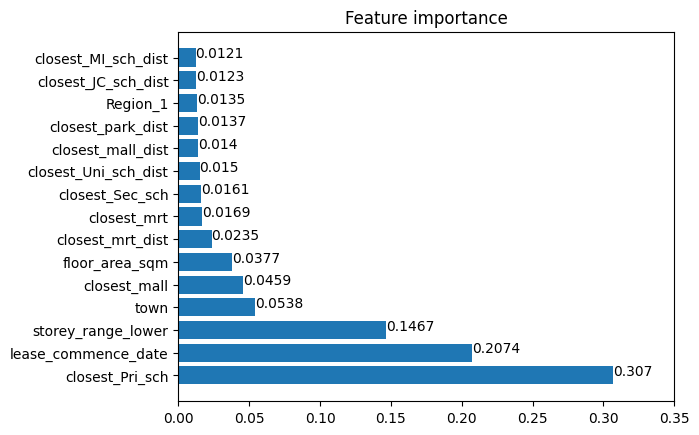

In [16]:
plt.barh([i for i in feature_importance_df['columns'][:15]], [i for i in feature_importance_df['importance'][:15]])
for idx, row in feature_importance_df.iloc[:15].iterrows():
    plt.annotate(
        round(row['importance'],4),
        (row['importance'], idx)
    )

plt.title('Feature importance')
plt.xlim([0,0.35])
plt.show()

In [17]:
selected_cols = feature_importance_df['columns'][:30]
print(len(selected_cols))
print(selected_cols)

30
0              closest_Pri_sch
1          lease_commence_date
2           storey_range_lower
3                         town
4                 closest_mall
5               floor_area_sqm
6             closest_mrt_dist
7                  closest_mrt
8              closest_Sec_sch
9         closest_Uni_sch_dist
10           closest_mall_dist
11           closest_park_dist
12                    Region_1
13         closest_JC_sch_dist
14         closest_MI_sch_dist
15        closest_Pri_sch_dist
16        closest_Sec_sch_dist
17               density_km_sq
18                closest_park
19                  Population
20                  area_km_sq
21      num_Pri_sch_1km_radius
22         num_mall_1km_radius
23                 flat_type_2
24      num_Sec_sch_1km_radius
25                flat_model_1
26            closest_JC_sch_2
27                flat_model_2
28    num_of_dwellings_in_town
29          num_mrt_1km_radius
Name: columns, dtype: object


In [18]:
# Select 30 out of 52 features based on feature importance
X_train = X_train[selected_cols]
X_test = X_test[selected_cols]

# 6. Model Selection

In [19]:
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import joblib

In [20]:
model_results = pd.DataFrame()

### 6.1 Linear Regression (Baseline)

In [21]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

pred = lr_model.predict(X_test)
mse= mean_squared_error(y_test, pred)
r2 = r2_score(y_test, pred)
print (f"VAL_SCORE (MSE): {mse}")
print (f"VAL_SCORE (R2): {r2}")

model_results = model_results.append({'Model': 'Linear Regression', 'MSE': mse, 'RMSE': np.sqrt(mse), 'R2': r2}, ignore_index=True)
model_results

VAL_SCORE (MSE): 488622.98888314667
VAL_SCORE (R2): 0.7265547512733295


,Model,MSE,RMSE,R2
0,Linear Regression,488622.988883,699.015729,0.726555


### 6.2 Lasso Regression

In [22]:
lasso_model = Lasso()
params = {'alpha': [0, 0.01, 0.1, 1]}
clf = GridSearchCV(lasso_model, params)
clf.fit(X_train, y_train)

GridSearchCV(estimator=Lasso(), param_grid={'alpha': [0, 0.01, 0.1, 1]})

In [23]:
lasso_model = Lasso(**clf.best_params_)
lasso_model.fit(X_train, y_train)

pred = lasso_model.predict(X_test)
mse= mean_squared_error(y_test, pred)
r2 = r2_score(y_test, pred)
print (f"VAL_SCORE (MSE): {mse}")
print (f"VAL_SCORE (R2): {r2}")
model_results = model_results.append({'Model': 'Lasso Regression', 'MSE': mse, 'RMSE': np.sqrt(mse), 'R2': r2}, ignore_index=True)
model_results


VAL_SCORE (MSE): 488622.73389888654
VAL_SCORE (R2): 0.7265548939686919


,Model,MSE,RMSE,R2
0,Linear Regression,488622.988883,699.015729,0.726555
1,Lasso Regression,488622.733899,699.015546,0.726555


### 6.3 Random Forest Regression (with hyperopt tuning)

In [24]:
# Hyperparameter tuning space
space = {
    'max_depth': hp.quniform('max_depth', 10, 1200, 5),
    'max_features': hp.choice('max_features', ['auto', 'sqrt','log2', None]),
    'min_samples_leaf': hp.uniform('min_samples_leaf', 0, 0.5),
    'min_samples_split' : hp.quniform ('min_samples_split', 2, 10, 1),
    'n_estimators' : hp.quniform('n_estimators', 160, 280, 10),
        
    }

# Objective function for regression: 
def hyperparameter_tuning(space):
    
    # Initialise model
    model = RandomForestRegressor(
        max_depth = int(space['max_depth']),
        max_features = space['max_features'],
        min_samples_leaf = space['min_samples_leaf'],
        min_samples_split = int(space['min_samples_split']),
        n_estimators = int(space['n_estimators'])
        )
  
    evaluation = [(X_train, y_train), (X_test, y_test)]
    model.fit(
        X_train, 
        y_train,
    )

    pred = model.predict(X_test)
    mse= mean_squared_error(y_test, pred)
    # r2 = r2_score(y_test, pred)
    # print (f"VAL_SCORE (MSE): {mse}")
    # print (f"VAL_SCORE (R2): {r2}")
    return {'loss':mse, 'status': STATUS_OK, 'model': model}

# Run trials
trials = Trials()
best = fmin(
    fn=hyperparameter_tuning,
    space=space,
    algo=tpe.suggest,
    max_evals=100,
    trials=trials
    )

print (best)

100%|██████████| 100/100 [36:36<00:00, 21.96s/trial, best loss: 258029.02807771866]
{'max_depth': 465.0, 'max_features': 2, 'min_samples_leaf': 7.642415696857514e-05, 'min_samples_split': 7.0, 'n_estimators': 180.0}


In [25]:
rf_model = RandomForestRegressor(
        max_depth = int(best['max_depth']),
        max_features = best['max_features'],
        min_samples_leaf = best['min_samples_leaf'],
        min_samples_split = int(best['min_samples_split']),
        n_estimators = int(best['n_estimators'])
)

rf_model.fit(
    X_train,
    y_train
)

pred = rf_model.predict(X_test)
mse= mean_squared_error(y_test, pred)
r2 = r2_score(y_test, pred)
print (f"VAL_SCORE (MSE): {mse}")
print (f"VAL_SCORE (R2): {r2}")

model_results = model_results.append({'Model': 'Random Forest', 'MSE': mse, 'RMSE': np.sqrt(mse), 'R2': r2}, ignore_index=True)
model_results

VAL_SCORE (MSE): 268875.26993413735
VAL_SCORE (R2): 0.849530892454236


,Model,MSE,RMSE,R2
0,Linear Regression,488622.988883,699.015729,0.726555
1,Lasso Regression,488622.733899,699.015546,0.726555
2,Random Forest,268875.269934,518.531841,0.849531


In [26]:
# Save model
joblib.dump(rf_model, 'rf_model.joblib')

['rf_model.joblib']

In [27]:
# Load model
loaded_rf = joblib.load("rf_model.joblib")

### 6.4 XGBoost (with hyperopt tuning)

In [28]:
# Hyperparameter tuning space
space = {
    'max_depth': hp.quniform("max_depth", 3, 26, 1),
    'gamma': hp.uniform ('gamma', 1,9),
    'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
    'reg_lambda' : hp.uniform('reg_lambda', 0,1),
    'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
    'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
    'n_estimators': hp.quniform('n_estimators', 160, 280, 10),
    }

# Objective function for regression: 
def hyperparameter_tuning(space):
    
    # Initialise model
    model = xgb.XGBRegressor(
        n_estimators =int(space['n_estimators']), 
        max_depth = int(space['max_depth']), 
        gamma = space['gamma'],
        reg_alpha = int(space['reg_alpha']),
        min_child_weight=space['min_child_weight'],
        colsample_bytree=space['colsample_bytree']
        )
  
    evaluation = [(X_train, y_train), (X_test, y_test)]
    model.fit(
        X_train, 
        y_train,
        eval_set=evaluation, 
        eval_metric="rmse",
        early_stopping_rounds=10,
        verbose=False
    )

    pred = model.predict(X_test)
    mse= mean_squared_error(y_test, pred)
    # r2 = r2_score(y_test, pred)
    return {'loss':mse, 'status': STATUS_OK, 'model': model}

# Run trials
trials = Trials()
best = fmin(
    fn=hyperparameter_tuning,
    space=space,
    algo=tpe.suggest,
    max_evals=100,
    trials=trials
    )

print (best)

100%|██████████| 100/100 [09:30<00:00,  5.70s/trial, best loss: 245856.47351971126]
{'colsample_bytree': 0.7182911422418133, 'gamma': 8.914524097879848, 'max_depth': 8.0, 'min_child_weight': 9.0, 'n_estimators': 240.0, 'reg_alpha': 159.0, 'reg_lambda': 0.7614538698029224}


In [29]:
# trials.trials
# trials.results
# plt.plot(trials.losses())
# plt.show()

In [30]:
xgb_model = xgb.XGBRegressor(
    colsample_bytree = best['colsample_bytree'],
    gamma = best['gamma'],
    max_depth = int(best['max_depth']),
    min_child_weight = int(best['min_child_weight']),
    reg_alpha = int(best['reg_alpha']),
    reg_lambda = best['reg_lambda'],
    n_estimators = int(best['n_estimators'])
    )

xgb_model.fit(
    X_train,
    y_train
)

pred = xgb_model.predict(X_test)
mse= mean_squared_error(y_test, pred)
r2 = r2_score(y_test, pred)
print (f"VAL_SCORE (MSE): {mse}")
print (f"VAL_SCORE (R2): {r2}")

model_results = model_results.append({'Model': 'XGBoost', 'MSE': mse, 'RMSE': np.sqrt(mse), 'R2': r2}, ignore_index=True)
model_results

VAL_SCORE (MSE): 255621.8532033787
VAL_SCORE (R2): 0.8569478251751137


,Model,MSE,RMSE,R2
0,Linear Regression,488622.988883,699.015729,0.726555
1,Lasso Regression,488622.733899,699.015546,0.726555
2,Random Forest,268875.269934,518.531841,0.849531
3,XGBoost,255621.853203,505.590598,0.856948


In [31]:
# Save model to JSON
xgb_model.save_model("xgb_model.json")

In [32]:
# Load model
loaded_model = xgb.XGBRegressor()
loaded_model.load_model("xgb_model.json")

### Plotting results of final model

In [33]:
model_results

,Model,MSE,RMSE,R2
0,Linear Regression,488622.988883,699.015729,0.726555
1,Lasso Regression,488622.733899,699.015546,0.726555
2,Random Forest,268875.269934,518.531841,0.849531
3,XGBoost,255621.853203,505.590598,0.856948


In [34]:
best_model = xgb.XGBRegressor()
best_model.load_model("xgb_model.json")

In [35]:
best_model.fit(
    X_train,
    y_train
)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7182911422418133, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float', 'float',
                            'float', 'float', 'float', 'float', 'float',
                            'float', 'float', 'int', 'float', 'float', 'float',
                            'f...
             gamma=8.914524097879848, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
             max_leaves=None, min_child_weight=9, missing=nan,
             monotone_constraints=None, n_estimators=240, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None, ...)

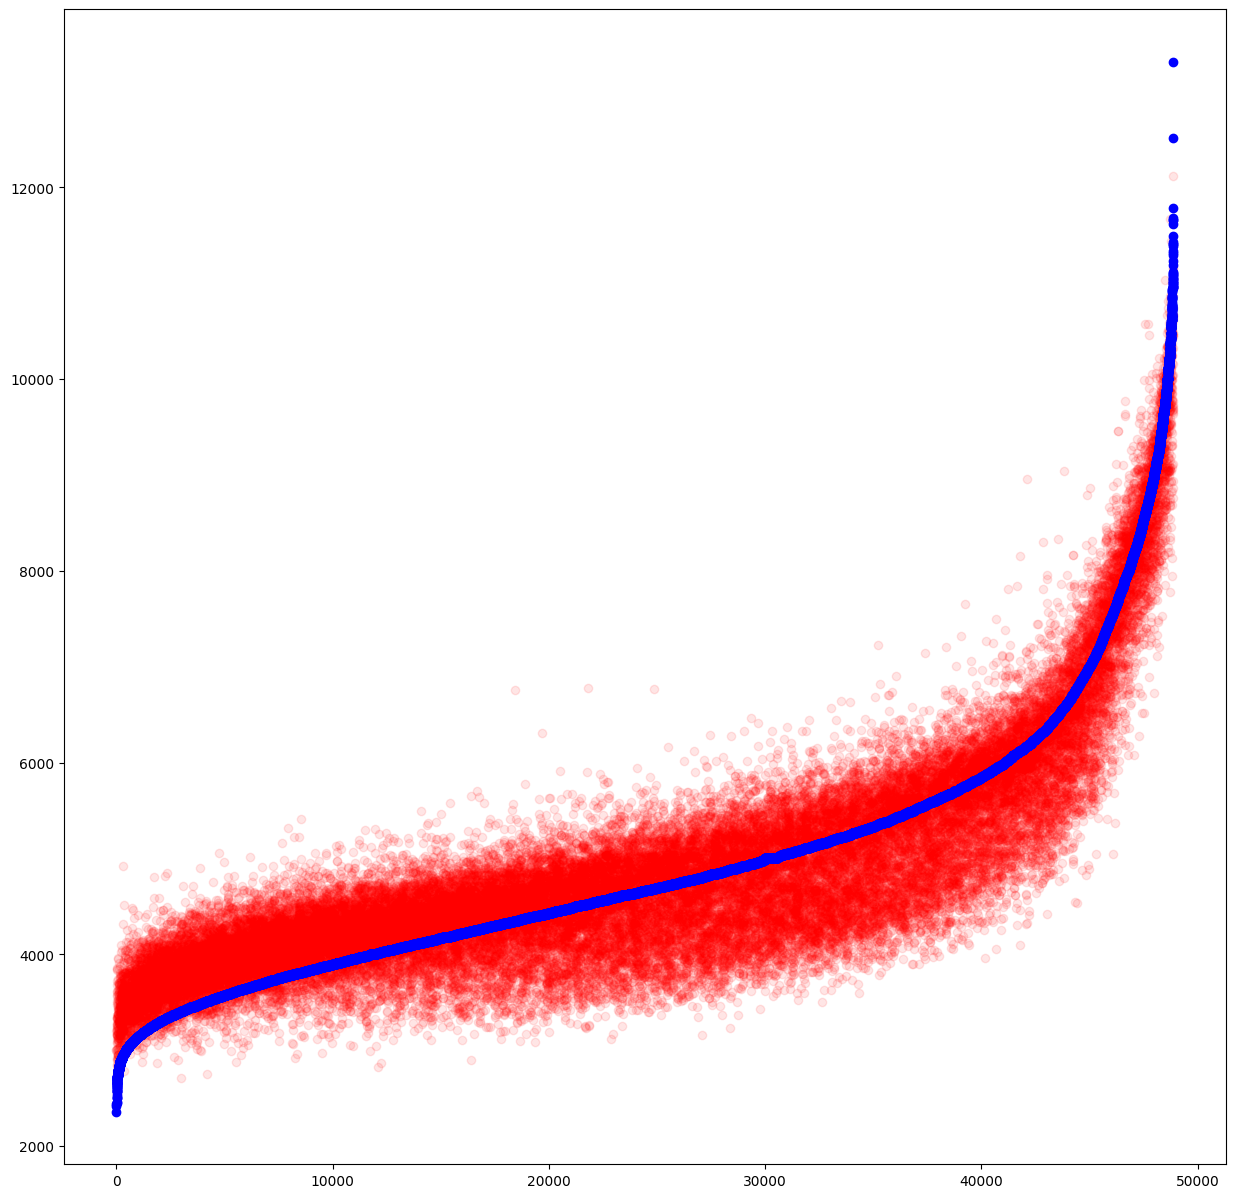

In [38]:
results = pd.DataFrame({'actual': y_test.iloc[:,0].values, 'pred': pred})
results = results.sort_values(['actual'])
results = results.reset_index(drop=True)

plt.figure(figsize=(15,15))
plt.scatter(x = results.index, y = results['pred'], alpha = 0.1, color = 'r')
plt.scatter(x = results.index, y = results['actual'], color = 'b')
plt.show()